# REINFORCE

Пусть $X$ это какая-то случайная величина с известным распределением $p_\theta(X)$, где $\theta$ — это параметры модели. Определим функцию награды $J(\theta)$ как

$$ J(\theta) = E[f(X)] = \int_x f(x) p(x) \; dx $$

для произвольной функции $f$, не зависящей от $\theta$.

*Policy gradient* (дословно, градиент стратегии) — это, интуитивно, то направление, куда нужно двигать параметры модели, чтобы функция награды увеличивалась. Алгоритм REINFORCE (почему его всегда пишут капсом автор не знает) на каждом шаге просто определяет policy gradient $\nabla_\theta J(\theta)$ и изменяет параметры в его сторону с каким-то learning rate-ом.

**Зачем это надо**, если есть обычный градиентный спуск? Через policy gradient и reinforcement learning вообще можно оптимизировать более общий класс функций — хоть дискретные (например, можно BLEU для перевода напрямую максимизировать) и даже невычислимые (какие-нибудь субъективные оценки асессоров).

В частности, в таком ключе можно описать игры (для простоты, однопользовательские): есть какие-то награды за совершение каких-то действий (для шахмат: +1 за победу, 0 за ничью, -1 за поражение; для тетриса: +0.1 за «выживание» ещё одну секунду, 1 за удаление слоя, 0 за проигрыш) и нам нужно подобрать такие параметры модели, чтобы максимизировать ожидаемую сумму наград за действия, которые мы совершили, то есть в точности $J(\theta)$.

Теперь немного математики: как нам найти этот $\nabla_\theta J(\theta)$? Оказывается, мы можем выразить его ожидание, а тогда приблизительный градиент можно будет находить сэмплированием и усреднением градиентов — так же, как мы обычно обучаем нейросети на батчах.

$$ J(\theta) = E[f(X)] = \int_x f(x) p(x) \; dx = \int_x f(x) p(x) \nabla_\theta \log p(x) \; dx = E[f(x) \nabla_\theta \log p(x)] $$

Переход между 2 и 3 верен, потому что $\nabla \log p(x) = \frac{\nabla p(x)}{p(x)}$ (просто подставьте и $p(x)$ сократится). Это называют log-derivative trick.

Мы научились получить приблизительный градиент через сэмплирование. Давайте теперь что-нибудь обучим.

## `CartPole-v0`

Про задачу можно почитать тут: https://gym.openai.com/envs/CartPole-v0/. Tl;dr: есть вертикально стоящая палка на подвижной платформе; нужно двигать платформу так, чтобы палка не упала.

<img width='500px' src='https://preview.redd.it/sqjzj2cgnpt21.gif?overlay-align=bottom,left&overlay-pad=8,16&crop=1200:628.272251309,smart&overlay-height=0.10&overlay=%2Fv9vyirk6hl221.png%3Fs%3Db466421949eb723078743745ce6421609d7a9c66&width=1200&height=628.272251309&s=ba84ac5a9c14946456808c15f2754cb7369b8de9'>

OpenAI в 2016-м году выпустили `gym` — библиотечку для абстрагирования RL-ных сред от алгоритма. Есть абстрактная *среда* (`env`), в ней есть какие-то *состояния* (`state`), из каждого состояния есть какой-то фиксированный набо *действий* (`action`), ведущих (возможно, с какими-то вероятностями) в другие состояния, и за разные действия в разных состояниях дается какая-то *награда* (`reward`). Как конкретно устроена игра, нам думать не нужно.

In [46]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [47]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

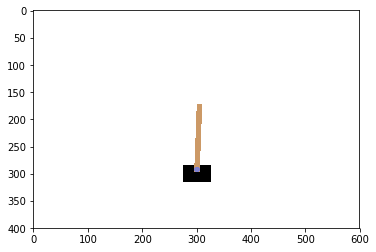

In [49]:
plt.imshow(env.render("rgb_array"))
env.close()

## Сеть

Для REINFORCE вам нужна модель, которая берёт на вход состояние (каким-то образом закодированное) и возвращает вероятностное распределение действий в нём.

Старайтесь не перемудрить — в общем случае сети для RL могут быть [довольно сложными](https://d4mucfpksywv.cloudfront.net/research-covers/openai-five/network-architecture.pdf), но CartPole не стоит того, чтобы писать глубокие архитектуры.

In [50]:
import torch
import torch.nn as nn

In [51]:
agent = nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
    # ...
    # какие-нибудь релушки и линеары
    # ...
    nn.LogSoftmax(dim=1)  # важно, что на выходе должны быть не вероятности, а логиты
)

OpenAI Gym работает с numpy, а не напрямую с фреймворками. Для удобства, напишите функцию-обёртку, которая принимает состояния (`numpy array` размера `[batch, state_shape]`) и возвращает вероятности (размера `[batch, n_actions]]`, должны суммироваться в единицу).

In [52]:
def predict_proba(states):
    x = torch.tensor(states, dtype=torch.float64).float()
    x = agent(x)
    return x, torch.exp(x)
    # сконвертируйте состояния в тензор
    # вычислите логиты
    # вызовите софтмакс, чтобы получить веряотности

In [53]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_proba(test_states)
print(test_probas)
# assert isinstance(test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
# assert tuple(test_probas.shape) == (test_states.shape[0], n_actions), "wrong output shape: " +  str(np.shape(test_probas))
# assert np.allclose(np.sum(test_probas, axis = 1), 1), "probabilities do not sum to 1"

(tensor([[-1.0189, -0.4478],
        [-1.0160, -0.4495],
        [-1.0174, -0.4487],
        [-1.0181, -0.4483],
        [-1.0154, -0.4498]], grad_fn=<LogSoftmaxBackward>), tensor([[0.3610, 0.6390],
        [0.3620, 0.6380],
        [0.3615, 0.6385],
        [0.3613, 0.6387],
        [0.3622, 0.6378]], grad_fn=<ExpBackward>))


## Тестовый прогон

Хоть наша модель не обучена, её уже можно использовать, чтобы играть в произвольной среде.

In [54]:
def generate_session(t_max=1000, draw=False):
    """ 
    Играет одну сессию REINFORCE-агентом и возвращает последовательность состояний,
    действий и наград, которые потом будут использоваться при обучении.
    """
    
    # тут будем хранить сессию
    states, actions, rewards, log_probas, probas = [],[],[], torch.tensor([]), torch.tensor([])
    
    s = env.reset()
    
    for t in range(t_max):
#         print(t)
        if draw:
            env.render("rgb-array")
        # вероятности следующих действий, aka p(a|s)
        log_action_probas, action_probas = predict_proba(np.array([s]))
        log_probas = torch.cat([log_probas, log_action_probas])
        probas = torch.cat([probas, action_probas])
        # сэмплируйте оттуда действие (посказка: np.random.choice)
        a = np.random.choice([0, 1], p=action_probas[0].detach().numpy())
        
        new_s, r, done, info = env.step(a)
        
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done:
            break
    return states, actions, rewards, log_probas, probas

In [55]:
# протестируйте
states, actions, rewards, logprobas, probas = generate_session()

### Computing cumulative rewards

In [56]:
def get_cumulative_rewards(rewards, gamma=0.99):
    """
    Принимает массив ревардов и возвращает discounted массив по следующей формуле:
    
        G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    Тут нет ничего сложного -- итерируйтесь от последнего до первого
    и насчитывайте G_t = r_t + gamma*G_{t+1} рекуррентно.
    """
    G = np.zeros(len(rewards))
    G[-1] = rewards[-1]
    for i in range(len(rewards) - 2, -1, -1):
        G[i] = rewards[i] + gamma * G[i + 1]
    return G

In [57]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
                   [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
                   [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
                   [0, 0, 1, 2, 3, 4, 0])
print("Вроде норм")

Вроде норм


#### Loss function and updates

Вспомним, что нам нужно оптимизировать

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Используя REINFORCE, нам в алгоритме по сути нужно максимизировать немного другую функцию:

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

Когда мы будем вычислять её градиент, мы получим в точности policy gradient из REINFORCE.

In [58]:
def to_one_hot(y_tensor, n_dims=None):
    """ Конвертирует целочисленный вектор в one-hot матрицу. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [59]:
# тут определите оптимизатор для модели
# например, Adam с дефолтными параметрами
optimiser = torch.optim.Adam(agent.parameters())

def train_on_session(states, actions, rewards, logprobas, probas, gamma = 0.99):
    
    states = torch.tensor(states, dtype=torch.float32)
#     logprobas = torch.tensor(logprobas, dtype=torch.float32)
#     probas = torch.tensor(probas, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)
    
    # выберем и просуммируем лог-вероятности только для выбранных действий
    logprobas_for_actions = torch.sum(logprobas * to_one_hot(actions), dim=1)
    
    J_hat = 1 / len(states) * torch.dot(logprobas_for_actions, cumulative_returns) # формула для REINFORCE
    
#     # опционально: энтропийная регуляризация
    entropy_reg = -torch.sum(torch.exp(logprobas_for_actions) * logprobas_for_actions) / len(logprobas_for_actions) # вычислите среднюю энтропию вероятностей; не забудьте знак!
    
    loss = -J_hat + 0.1 * entropy_reg
    
    loss.backward()
    optimiser.step()
    agent.zero_grad()
#     # шагните в сторону градиента
#     # ....
    
#     # верните ревард сессии, чтобы потом их печатать
    return np.sum(rewards)

## Само обучение

In [60]:
for i in range(100):
    rewards = [train_on_session(*generate_session()) for _ in range(100)]
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 500:
        print ("Победа!")
        break

mean reward:17.610
mean reward:19.100
mean reward:22.340
mean reward:22.080
mean reward:21.720
mean reward:27.250
mean reward:24.780
mean reward:23.190
mean reward:29.810
mean reward:34.060
mean reward:40.530
mean reward:48.730
mean reward:53.490
mean reward:64.080
mean reward:93.080
mean reward:85.600
mean reward:93.200
mean reward:198.780
mean reward:191.280
mean reward:145.420
mean reward:200.670
mean reward:291.230
mean reward:158.160
mean reward:187.890
mean reward:161.720
mean reward:212.590
mean reward:279.560
mean reward:317.810
mean reward:133.900
mean reward:360.950
mean reward:487.390
mean reward:539.630
Победа!


## Видосик

In [61]:
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(draw=True) for _ in range(1)]
env.close()

In [62]:
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))